In [1]:
import ROOT as R

Welcome to JupyROOT 6.24/02


In [2]:
# note common binning is assumed

class ZprimeInterpolator2D:
    def __init__(self,tf,mns=200):
        self.mns=mns
        self.keys=[key.GetName() for key in R.gDirectory.GetListOfKeys()] 
        if mns==200:
            self.keys=filter(lambda x: "NS200" in x, self.keys)
        elif mns==1:
            self.keys=filter(lambda x: "NS1" in x, self.keys)
        else:
            print("error: use only mns = 1 or 200")
            return
        #keys=list(filter(lambda x: x.endswith("xs"), keys)) # lumixs sample
        #keys=list(filter(lambda x: x.endswith("combiner"), keys)) # combiner
        self.keys=list(filter(lambda x: not "xs" in x, self.keys)) # base sample
        #self.mzp=[]
        #self.mnd=[]
        h0=tf.Get(self.keys[0])
        self.nbins=h0.GetNbinsX()
        self.xmin=h0.GetXaxis().GetXmin()
        self.xmax=h0.GetXaxis().GetXmax()
        self.tg2d=[None]*self.nbins
        
        for ib in range(1,self.nbins+1):
            n=0
            tg2d=R.TGraph2D()
            for key in self.keys:
                hist=tf.Get(key)
                mzp=float(key[key.find("Zp")+len("Zp"):key.rfind("ND")])
                mnd=float(key[key.find("ND")+len("NS"):key.rfind("NS")])
                y=hist.GetBinContent(ib)
                # if mzp==2500 and mnd==600:
                #    print (ib,hist.GetBinContent(ib))
                #if ib==12:
                    #print(n,mzp,mnd,y)
                tg2d.SetPoint(n,mzp,mnd,y)
                n=n+1
            self.tg2d[ib-1]=tg2d


    def Interpolate(self,mzp,mnd):
        name=f"Zp{mzp}ND{mnd}NS{self.mns}"
        h=R.TH1D(f'i{name}',f'{name} interpolated;RJZ(mZp)',self.nbins,self.xmin,self.xmax)
        for ib in range(1,self.nbins+1):
            y=self.tg2d[ib-1].Interpolate(mzp,mnd)
            #print(self.tg2d[ib-1].GetN())
            #print(mzp,mnd,ib,y)
            #print(ib-1,self.tg2d[ib-1].Interpolate(mzp,mnd))
            h.SetBinContent(ib,y)
        return h

Usage
===
o) Create the interpolator by providing a ROOT file with all histograms, eg ranges of mZp, mNd (but fixed mNs!)
o) Call the Interpolate method with the mZp, mNd masses to calculate

In [3]:
tf=R.TFile("Run2_161718_ZllHbbMET_signals_Zptcut100_Hptcut300_metcut75_btagwp8E-10.root")
zpi=ZprimeInterpolator2D(tf)
#zpi.keys

Interpolation examples
====

In the examples below, mass combinations corresponding to the inoput data are shown in blue and with error bars.  Interpolated points are shown in red.

The left plot shows an interpolated value versus the four surrounding mass points in the input sample.  The right plots shows the interpolated distribution vs inputs to the left and right of the interpolated mZp value.

Warning in <TFile::Append>: Replacing existing TH1: iZp2500ND600NS200 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: iZp2500ND800NS200 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: iZp2500ND1000NS200 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: iZp2000ND800NS200 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: iZp3000ND800NS200 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: iZp2500ND1000NS200 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: iZp3300ND1000NS200 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: iZp5500ND1000NS200 (Potential memory leak).


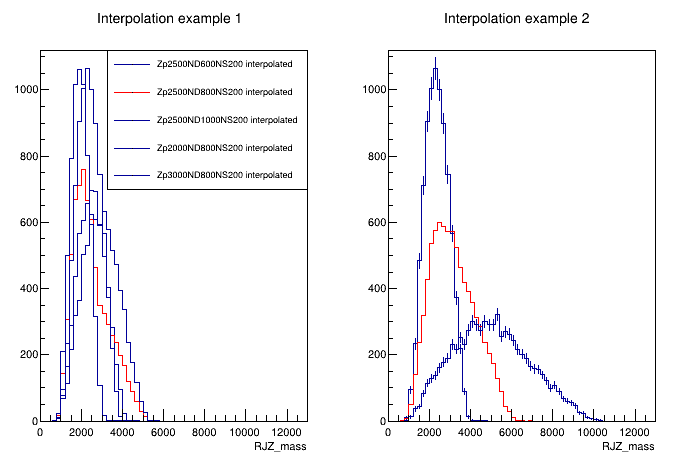

In [57]:
tc=R.TCanvas()
tc.Divide(2,1)
tc.cd(1)  # interpolate to point 2500,800 in TPad 1

hs1 = R.THStack("hs1","Interpolation example 1;RJZ_mass")
#hs1.Add(tf.Get("Zp2500ND600NS200"))
#hs1.Add(tf.Get("Zp2500ND1000NS200"))

legend = R.TLegend(0.3, 0.6, .9, .9)
R.gStyle.SetLegendTextSize(0.03)

mzp=2500
for mnd in [600,800,1000]:
    h=zpi.Interpolate(mzp,mnd)
    if tf.Get(f"Zp{mzp}ND{mnd}NS200")==None:
        h.SetLineColor(R.kRed)
    hs1.Add(h)
    legend.AddEntry(h,"")

    
mnd=800
for mzp in [2000,3000]:
    h=zpi.Interpolate(mzp,mnd)
    if tf.Get(f"Zp{mzp}ND{mnd}NS200")==None:
        h.SetLineColor(R.kRed)
    hs1.Add(h)
    legend.AddEntry(h,"")
    
hs1.Draw("nostack")
legend.Draw()


tc.cd(2)

hs2 = R.THStack("hs2","Interpolation example 2;RJZ_mass")
hs2.Add(tf.Get("Zp2500ND1000NS200"))
hs2.Add(tf.Get("Zp5500ND1000NS200"))

mnd=1000
for mzp in [2500,3300,5500]:
    h=zpi.Interpolate(mzp,mnd)
    if tf.Get(f"Zp{mzp}ND{mnd}NS200")==None:
        h.SetLineColor(R.kRed)
    hs2.Add(h)

hs2.Draw("nostack")

tc.Draw()

The plot on the right shows the values of bin 23 corresponding to ~4500GeV.  Diamonds mark the input mass points.   The circle shoes the location of the interpolared value for this bin in the red histogram.

Info in <TCanvas::Print>: pdf file test.pdf has been created


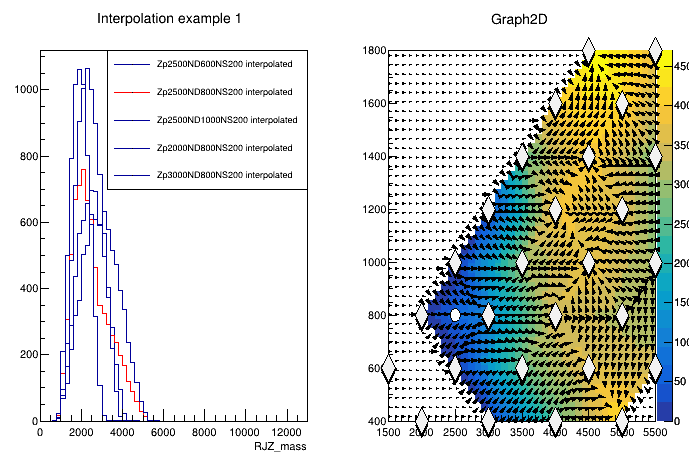

In [58]:
#bin 23 corresponds to mZp=4500 
zpi.tg2d[23].Draw("colz")
zpi.tg2d[23].Draw("arr,same")

for key in zpi.keys:
    hist=tf.Get(key)
    mzp=float(key[key.find("Zp")+len("Zp"):key.rfind("ND")])
    mnd=float(key[key.find("ND")+len("NS"):key.rfind("NS")])
    d=R.TDiamond(mzp-100,mnd-50,mzp+100,mnd+50).Clone()
    d.Draw()
    el = R.TEllipse(2500,800,80,25)
    el.Draw()

tc.Draw()

Noce demo plot shown below

In [65]:
tcd=R.TCanvas()
tcd.Divide(2,1)

Info in <TCanvas::Print>: pdf file interpolation.pdf has been created


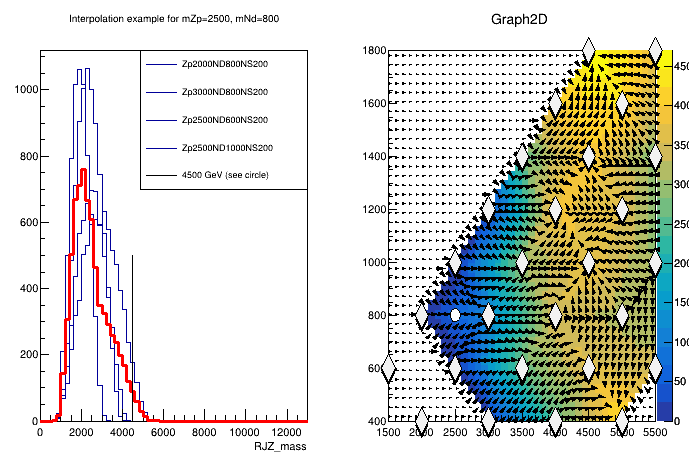

In [93]:
tcd.cd(1)
hs2 = R.THStack("hs2","Interpolation example for mZp=2500, mNd=800;RJZ_mass")
hs2.Add(tf.Get("Zp2000ND800NS200"))
hs2.Add(tf.Get("Zp3000ND800NS200"))
hs2.Add(tf.Get("Zp2500ND600NS200"))
hs2.Add(tf.Get("Zp2500ND1000NS200"))

legend = R.TLegend(0.4, 0.6, .9, .9)
legend.AddEntry(tf.Get("Zp2000ND800NS200"),"Zp2000ND800NS200","l")
legend.AddEntry(tf.Get("Zp3000ND800NS200"),"Zp3000ND800NS200","l")
legend.AddEntry(tf.Get("Zp2500ND600NS200"),"Zp2500ND600NS200","l")
legend.AddEntry(tf.Get("Zp2500ND1000NS200"),"Zp2500ND1000NS200","l")
legend.AddEntry(0,"4500 GeV (see circle)","l")
line=R.TLine(4500,0,4500,500)

h=zpi.Interpolate(2500,800)
h.SetLineColor(R.kRed)
h.SetLineWidth(3)
#hs2.Add(h)

hs2.Draw("nostack,hist")
h.Draw("same,hist")
legend.Draw()
line.Draw()

tcd.cd(2)
zpi.tg2d[23].Draw("colz")
zpi.tg2d[23].Draw("arr,same")

for key in zpi.keys:
    hist=tf.Get(key)
    mzp=float(key[key.find("Zp")+len("Zp"):key.rfind("ND")])
    mnd=float(key[key.find("ND")+len("NS"):key.rfind("NS")])
    d=R.TDiamond(mzp-100,mnd-50,mzp+100,mnd+50).Clone()
    d.Draw()
    el = R.TEllipse(2500,800,80,25)
    el.Draw()


tcd.Draw()
tcd.Print("interpolation.pdf")

3500.0

Warning in <TFile::Append>: Replacing existing TH1: iZp2250ND900NS200 (Potential memory leak).
Info in <TCanvas::Print>: pdf file interpolation_edge.pdf has been created


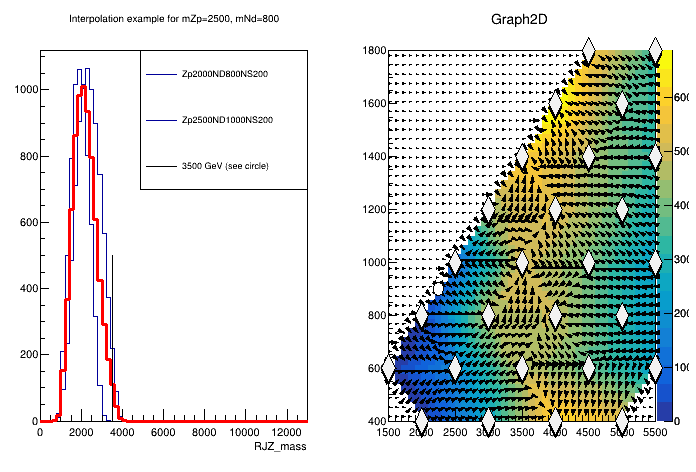

In [96]:
tcd.cd(1)
hs2 = R.THStack("hs2","Interpolation example for mZp=2500, mNd=800;RJZ_mass")
hs2.Add(tf.Get("Zp2000ND800NS200"))
hs2.Add(tf.Get("Zp2500ND1000NS200"))

legend = R.TLegend(0.4, 0.6, .9, .9)
legend.AddEntry(tf.Get("Zp2000ND800NS200"),"Zp2000ND800NS200","l")
legend.AddEntry(tf.Get("Zp2500ND1000NS200"),"Zp2500ND1000NS200","l")
legend.AddEntry(0,"3500 GeV (see circle)","l")
line=R.TLine(3500,0,3500,500)

h=zpi.Interpolate(2250,900)
h.SetLineColor(R.kRed)
h.SetLineWidth(3)
#hs2.Add(h)

hs2.Draw("nostack,hist")
h.Draw("same,hist")
legend.Draw()
line.Draw()

tcd.cd(2)
zpi.tg2d[18].Draw("colz")
zpi.tg2d[18].Draw("arr,same")

for key in zpi.keys:
    hist=tf.Get(key)
    mzp=float(key[key.find("Zp")+len("Zp"):key.rfind("ND")])
    mnd=float(key[key.find("ND")+len("NS"):key.rfind("NS")])
    d=R.TDiamond(mzp-100,mnd-50,mzp+100,mnd+50).Clone()
    d.Draw()
    el = R.TEllipse(2250,900,80,25)
    el.Draw()


tcd.Draw()
tcd.Print("interpolation_edge.pdf")
tf.Get("Zp2000ND800NS200").GetBinCenter(18)